## Adding a per-chrom filter on SNV density 

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df=all_pairs_dist_df[all_pairs_dist_df["direct_pairwise_dist"]< 0.2]

all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr,sample_pair
46,HG00741.2,HG01167.2,0.003675,chr6,HG00741.2_HG01167.2
984,NA19700.1,NA19835.1,0.079636,chr6,NA19700.1_NA19835.1
1224,HG02083.2,HG02129.2,0.176519,chr6,HG02083.2_HG02129.2
2003,HG02280.1,NA18879.1,0.134344,chr6,HG02280.1_NA18879.1
2046,HG02258.1,HG03583.2,0.105130,chr6,HG02258.1_HG03583.2


In [8]:
import pandas as pd
from pathlib import Path

base_path = Path(
    "/private/groups/migalab/juklucas/centrolign/variant_calling/rates"
)

allowed_pairs = set(
    all_pairs_dist_df
        .loc[all_pairs_dist_df["direct_pairwise_dist"] < 0.2, "sample_pair"]
)

dfs = []

for file in base_path.glob("*/snv_calls/induced/raw/*.snvs.csv"):
    chr_name = file.parts[file.parts.index("rates") + 1]

    # strip suffix
    name = file.name[:-len(".snvs.csv")]

    # split sample1 vs rest (ONLY reliable delimiter)
    sample1, rest = name.split("_", 1)

    # subgroup is optional but has a fixed prefix
    if ".subgroup_" in rest:
        sample2, subgroup = rest.split(".subgroup_", 1)
        subgroup = f"subgroup_{subgroup}"
    else:
        sample2 = rest
        subgroup = None

    sample_pair = "_".join(sorted((sample1, sample2)))

    if sample_pair not in allowed_pairs:
        continue

    df = pd.read_csv(file)

    df["chr"] = chr_name
    df["sample1"] = sample1
    df["sample2"] = sample2
    df["subgroup"] = subgroup
    df["sample_pair"] = sample_pair

    dfs.append(df)

all_snvs = pd.concat(dfs, ignore_index=True)



ERROR! Session/line number was not unique in database. History logging moved to new session 215


/data/tmp/ipykernel_1297425/121438843.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_snvs = pd.concat(dfs, ignore_index=True)


In [9]:
all_snvs.head()

,ref_id,qry_id,var_type,ref_pos,qry_pos,ref_base,qry_base,length,dist_to_break,local_snv_rate,local_snv_rate_percentile,pair,pass_dist,pass_rate,pass_filter,chr,sample1,sample2,subgroup,sample_pair
0,HG01934.2,HG01934.1,SNV,677,677,T,C,1,677.0,0.000187,6.081081,HG01934.2__HG01934.1,True,True,True,chr11,HG01934.2,HG01934.1,subgroup_A,HG01934.1_HG01934.2
1,HG01934.2,HG01934.1,SNV,7243,7243,G,T,1,7243.0,0.000116,2.413127,HG01934.2__HG01934.1,True,True,True,chr11,HG01934.2,HG01934.1,subgroup_A,HG01934.1_HG01934.2
2,HG01934.2,HG01934.1,SNV,18664,23915,G,A,1,11215.0,0.000100,0.868726,HG01934.2__HG01934.1,True,True,True,chr11,HG01934.2,HG01934.1,subgroup_A,HG01934.1_HG01934.2
3,HG01934.2,HG01934.1,SNV,24333,29584,A,C,1,5546.0,0.000109,2.220077,HG01934.2__HG01934.1,True,True,True,chr11,HG01934.2,HG01934.1,subgroup_A,HG01934.1_HG01934.2
4,HG01934.2,HG01934.1,SNV,36910,40461,C,T,1,1342.0,0.000225,11.486486,HG01934.2__HG01934.1,True,True,True,chr11,HG01934.2,HG01934.1,subgroup_A,HG01934.1_HG01934.2


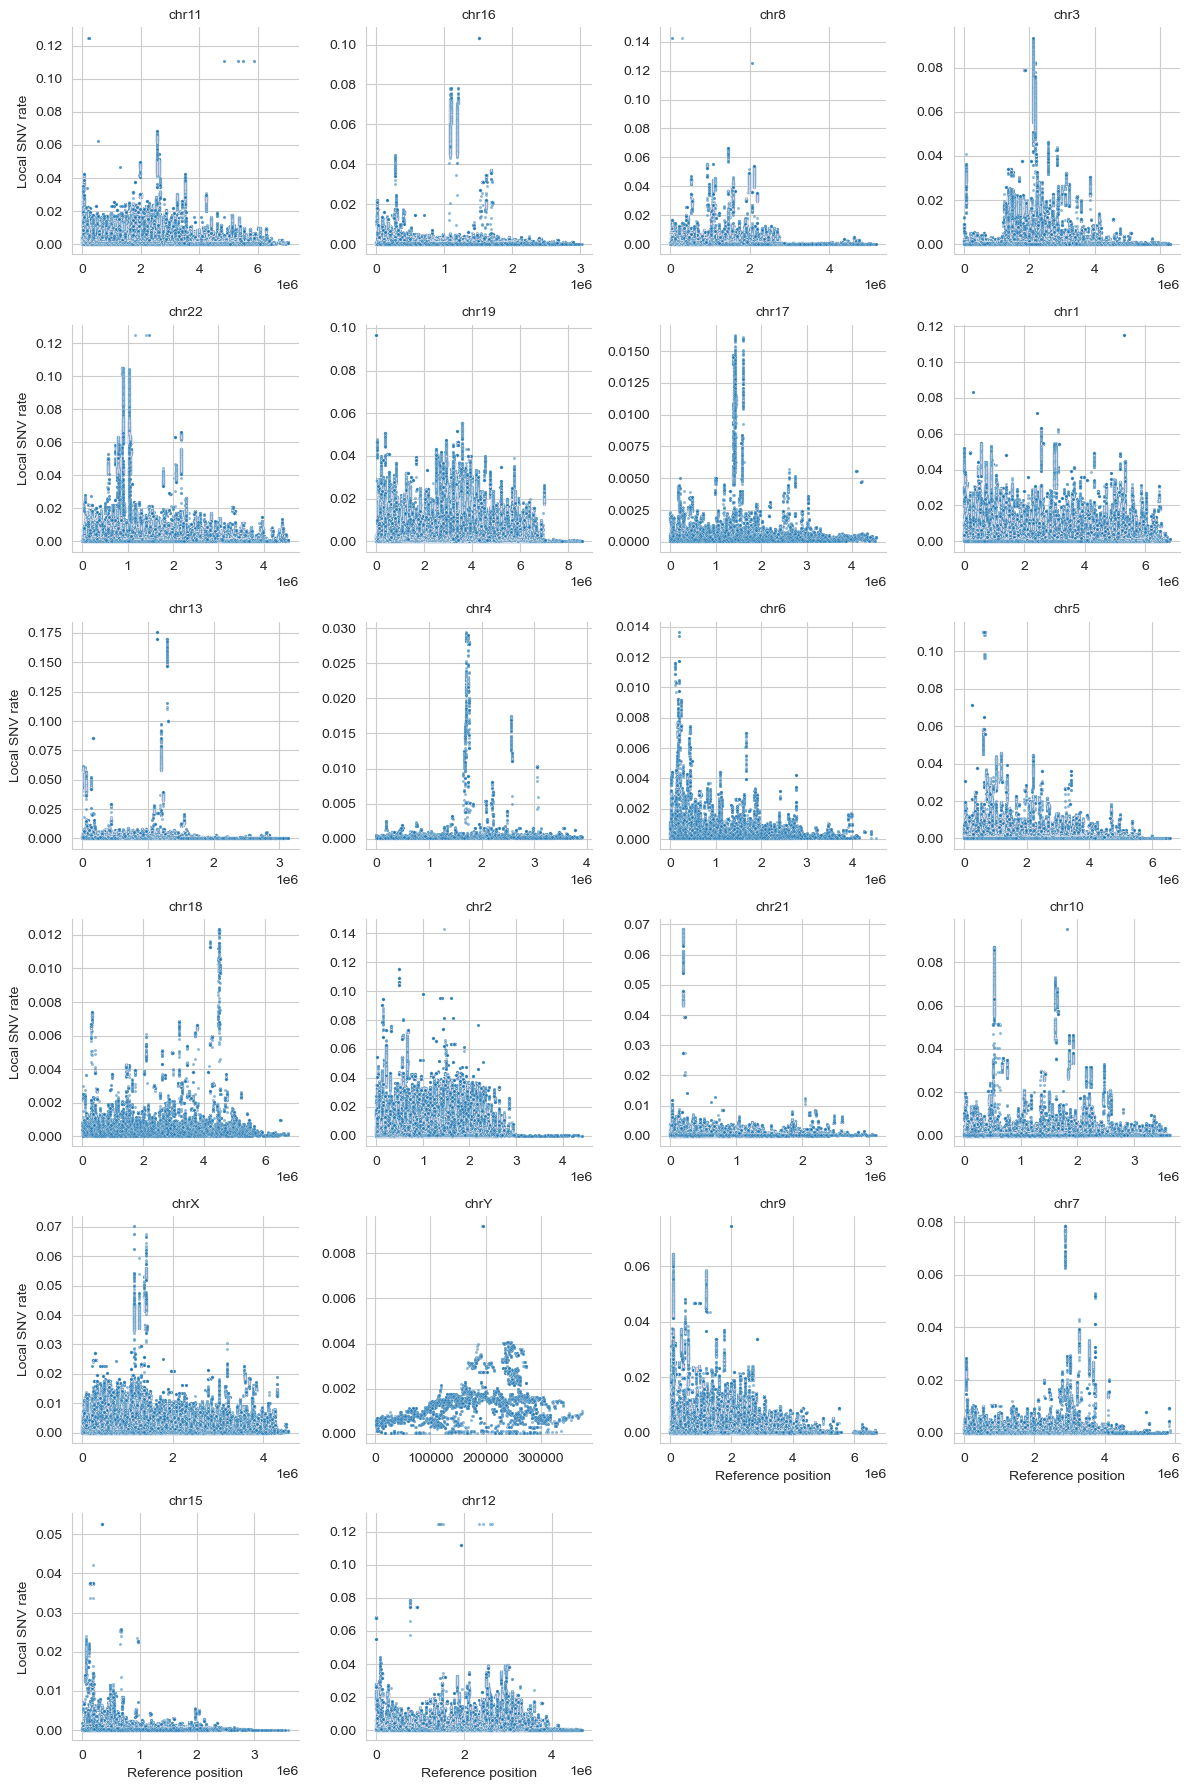

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

g = sns.FacetGrid(
    all_snvs,
    col="chr",
    col_wrap=4,      # adjust for layout
    height=3,
    sharex=False,
    sharey=False
)

g.map_dataframe(
    sns.scatterplot,
    x="ref_pos",
    y="local_snv_rate",
    s=5,
    alpha=0.5
)

g.set_axis_labels("Reference position", "Local SNV rate")
g.set_titles("{col_name}")

plt.tight_layout()
plt.show()


/data/tmp/ipykernel_1297425/557939049.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_iqr_outliers, col="local_snv_rate", k=3)


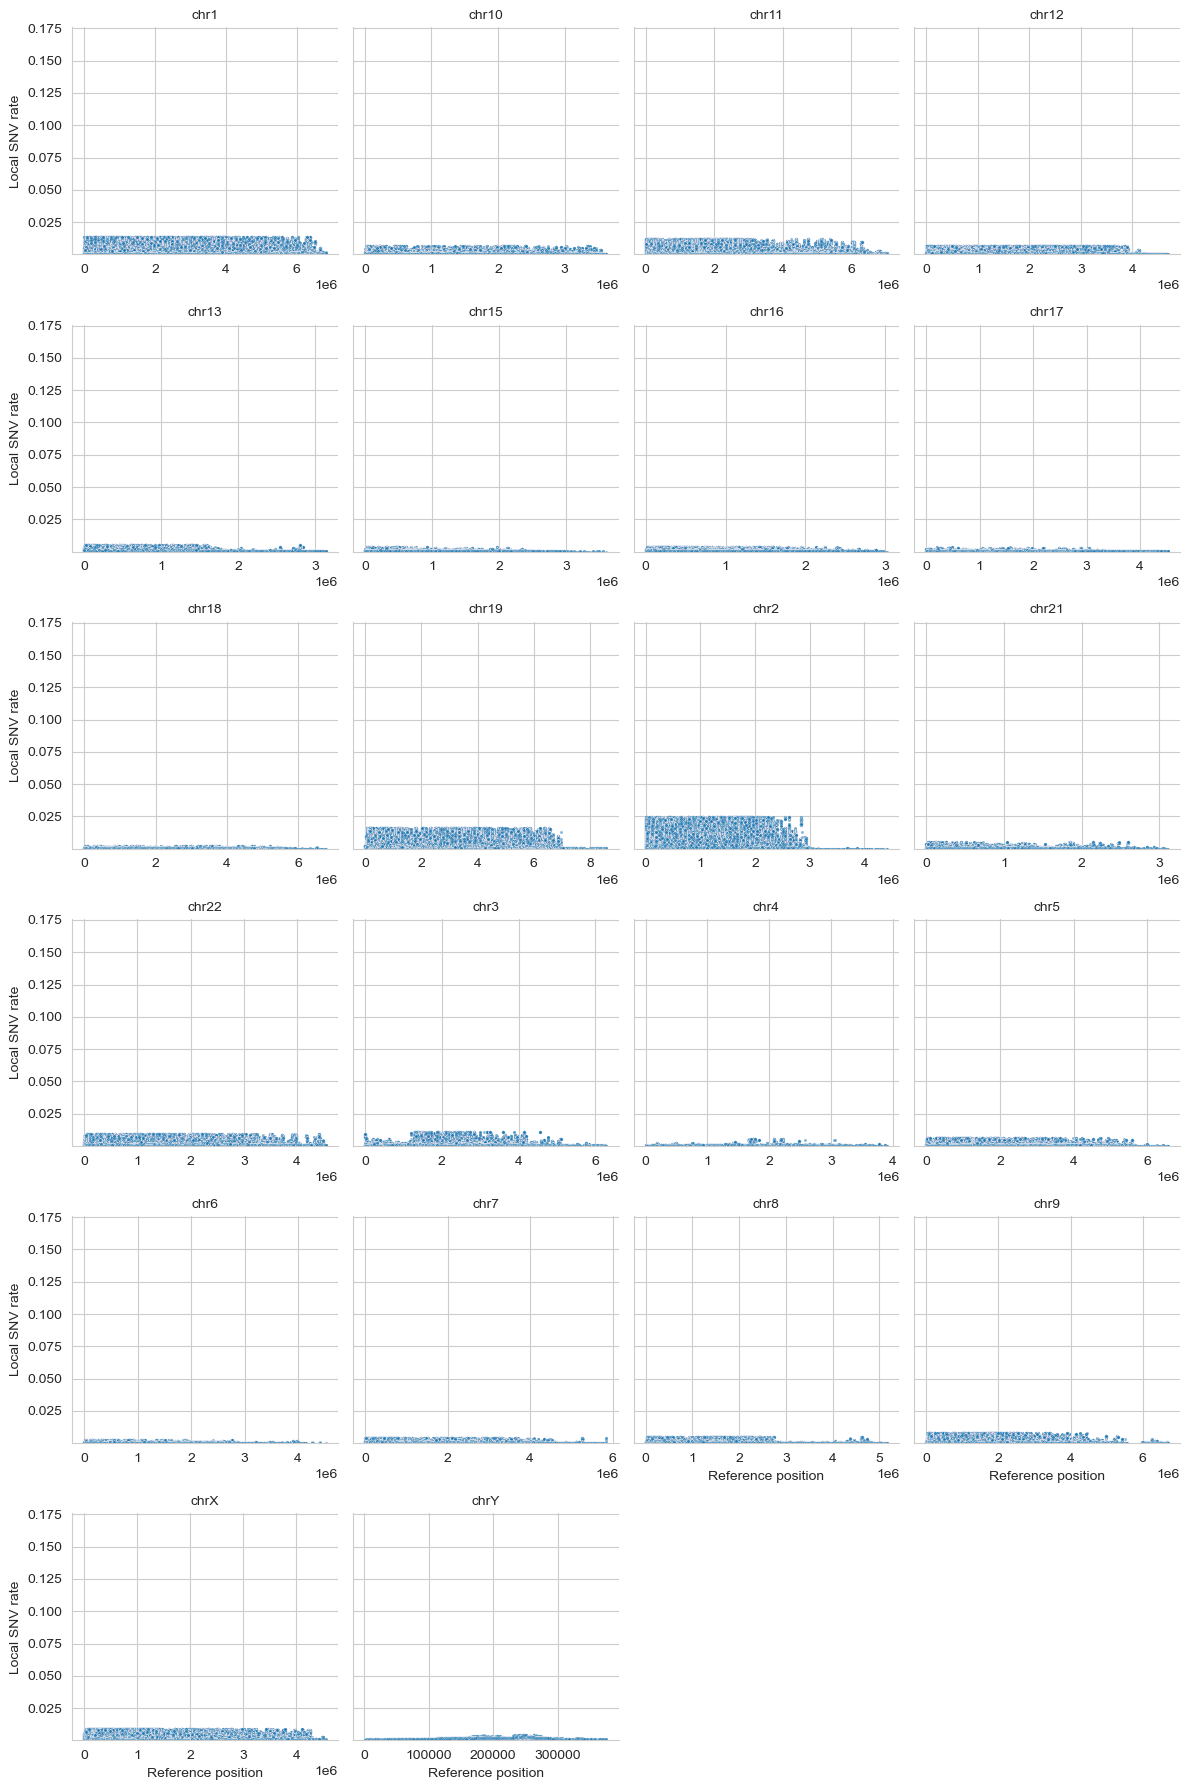

       n_original  n_filtered  n_removed  perc_removed
chr                                                   
chr1      1965262     1875766      89496      4.553897
chr10      341442      308892      32550      9.533098
chr11     2200322     2140182      60140      2.733236
chr12      773336      718347      54989      7.110622
chr13      159102      151103       7999      5.027592
chr15       94752       82478      12274     12.953816
chr16      372598      352744      19854      5.328531
chr17       30036       27563       2473      8.233453
chr18       32976       30007       2969      9.003518
chr19     1610124     1555716      54408      3.379119
chr2      3015154     2968183      46971      1.557831
chr21       99502       95724       3778      3.796909
chr22      946692      889695      56997      6.020649
chr3       183272      158257      25015     13.649112
chr4         9756        8208       1548     15.867159
chr5       467856      419967      47889     10.235842
chr6      

In [25]:
### removing 3 x IQR

ymin = all_snvs["local_snv_rate"].min()
ymax = all_snvs["local_snv_rate"].max()

def remove_iqr_outliers(df, col, k=10):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return df[(df[col] >= lower) & (df[col] <= upper)]

filtered_snvs = (
    all_snvs
    .groupby("chr", group_keys=False)
    .apply(remove_iqr_outliers, col="local_snv_rate", k=3)
)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

g = sns.FacetGrid(
    filtered_snvs,
    col="chr",
    col_wrap=4,
    height=3,
    sharex=False,
    sharey=True
)

g.map_dataframe(
    sns.scatterplot,
    x="ref_pos",
    y="local_snv_rate",
    s=5,
    alpha=0.5
)

g.set_axis_labels("Reference position", "Local SNV rate")
g.set_titles("{col_name}")

# force identical y-axis across facets
for ax in g.axes.flat:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

counts = (
    all_snvs
        .groupby("chr")
        .size()
        .rename("n_original")
        .to_frame()
        .join(
            filtered_snvs
                .groupby("chr")
                .size()
                .rename("n_filtered"),
            how="left"
        )
        .fillna(0)
        .astype(int)
)

counts["n_removed"] = counts["n_original"] - counts["n_filtered"]
counts["perc_removed"] = 100*(1 - (counts["n_filtered"] / counts["n_original"]))
print(counts)


In [ ]:
## Check how many IQRs away the outliers are 

/data/tmp/ipykernel_1297425/940062333.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_iqr_distance, col="local_snv_rate")


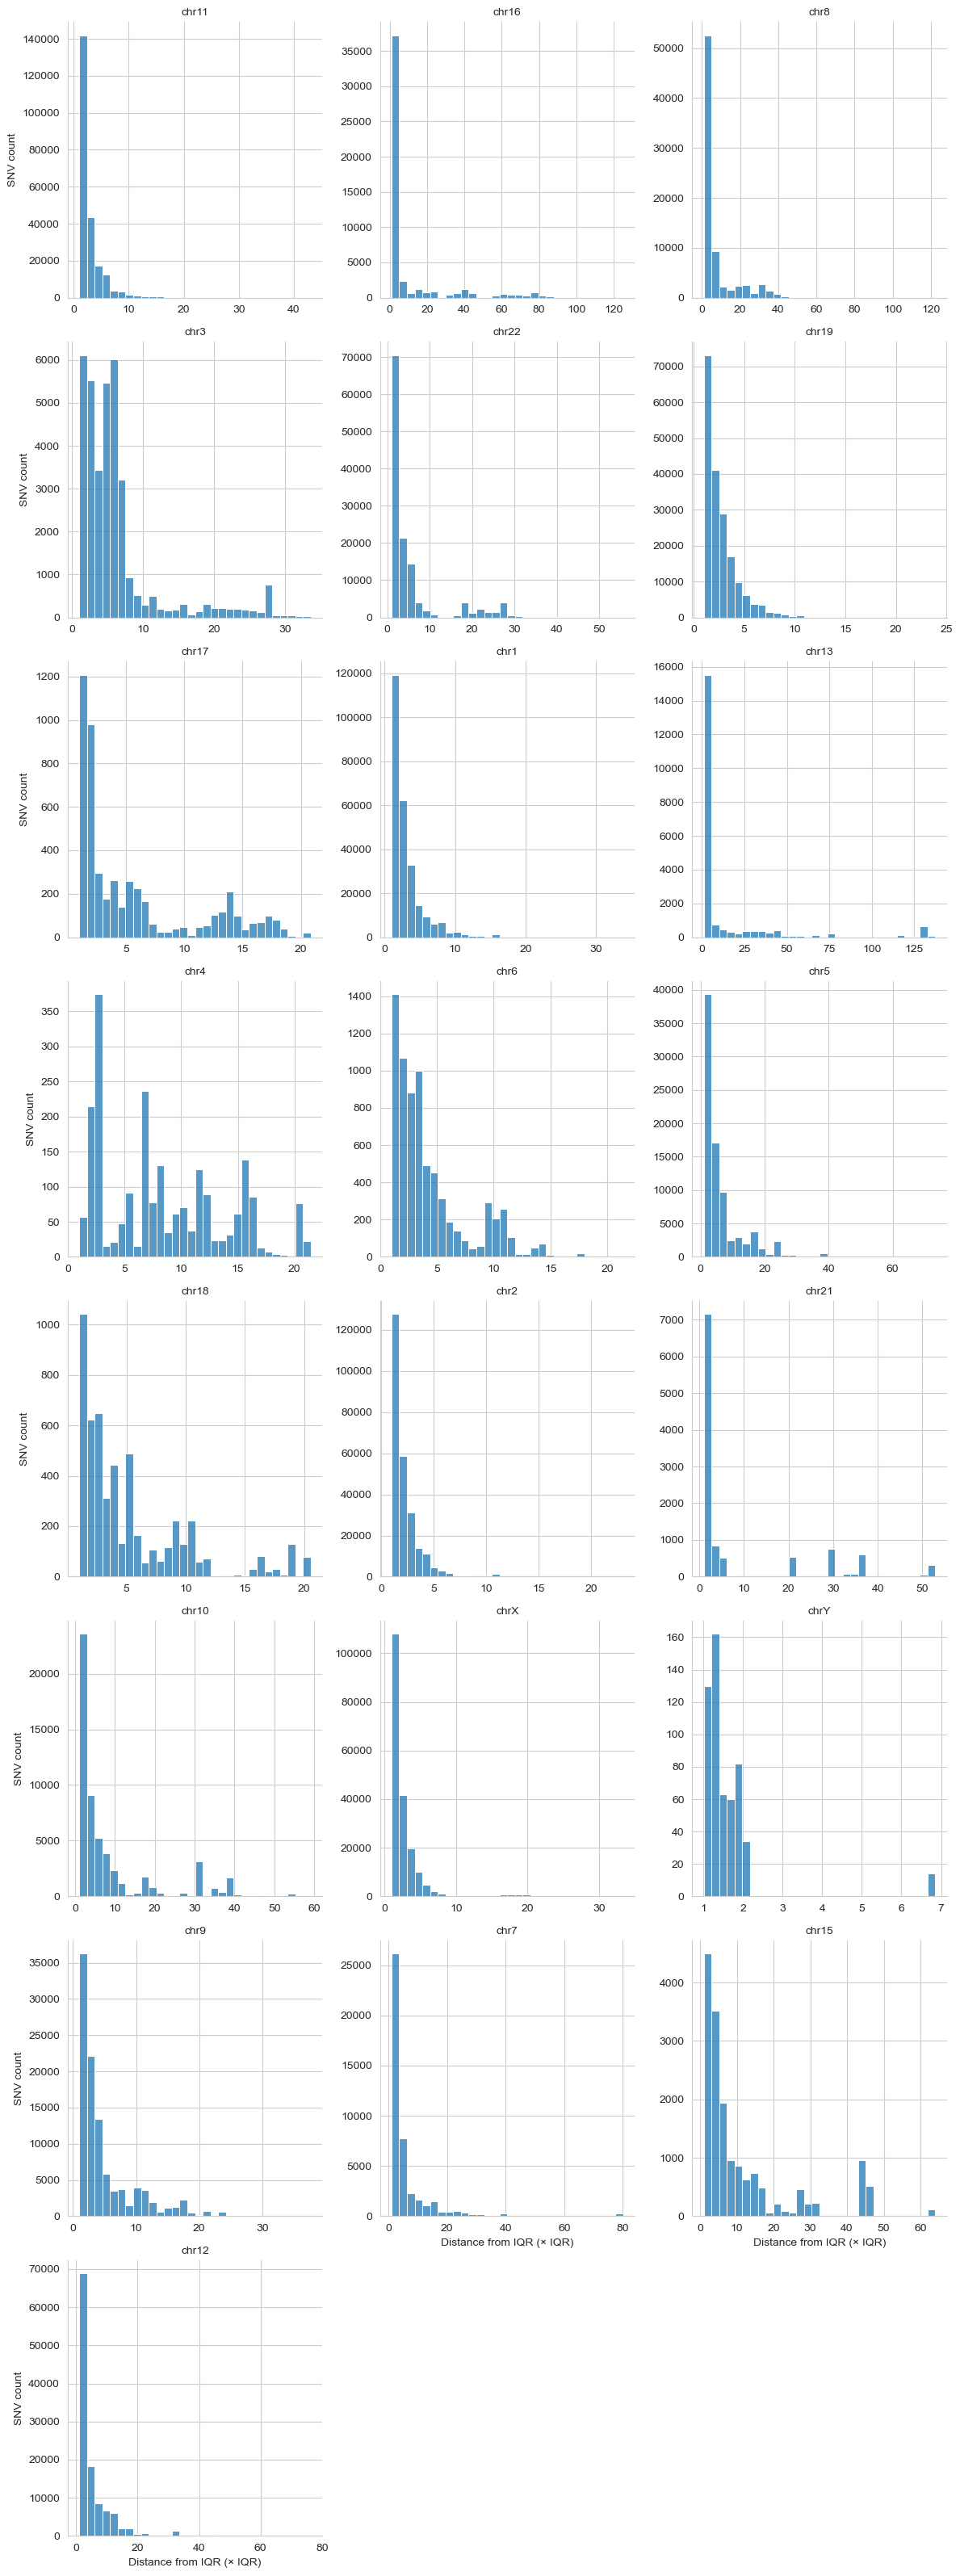

In [19]:
import numpy as np

def compute_iqr_distance(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    df = df.copy()
    df["iqr_distance"] = np.nan

    low_mask = df[col] < q1
    high_mask = df[col] > q3

    df.loc[low_mask, "iqr_distance"] = (q1 - df.loc[low_mask, col]) / iqr
    df.loc[high_mask, "iqr_distance"] = (df.loc[high_mask, col] - q3) / iqr

    return df

iqr_outliers = (
    all_snvs
        .groupby("chr", group_keys=False)
        .apply(compute_iqr_distance, col="local_snv_rate")
        .dropna(subset=["iqr_distance"])
)

iqr_outliers_gt1 = iqr_outliers[iqr_outliers["iqr_distance"] > 1]


import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

g = sns.FacetGrid(
    iqr_outliers_gt1,
    col="chr",
    col_wrap=3,
    height=4,
    sharex=False,
    sharey=False
)

g.map_dataframe(
    sns.histplot,
    x="iqr_distance",
    bins=30
)

g.set_axis_labels("Distance from IQR (× IQR)", "SNV count")
g.set_titles("{col_name}")

plt.tight_layout()
plt.show()



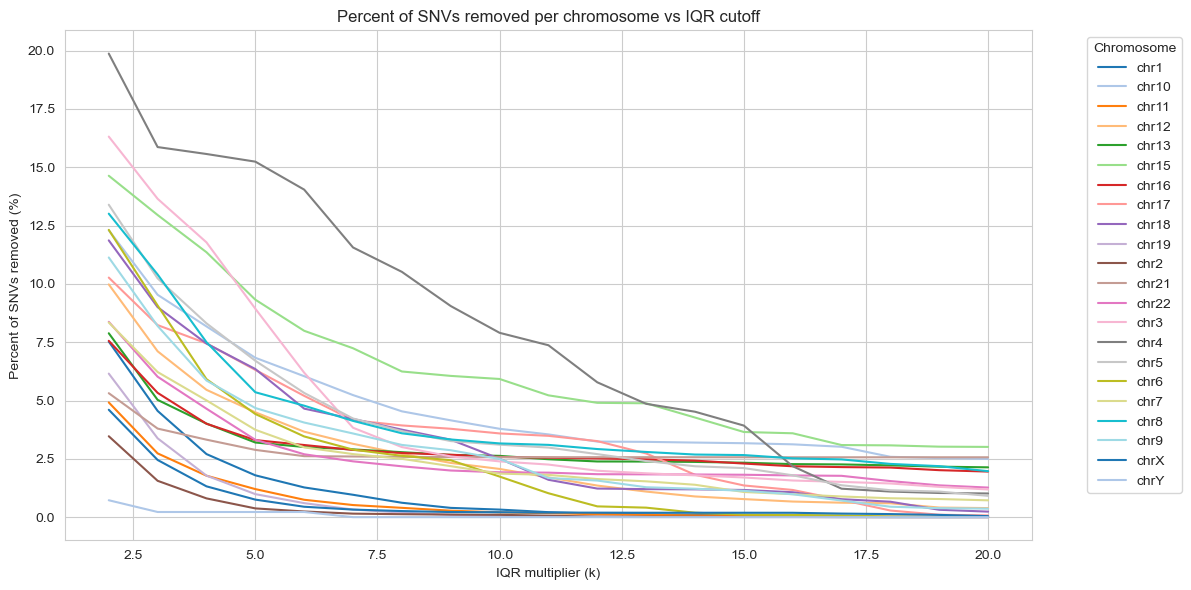

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. Compute percent removed per chromosome for IQR thresholds
# -----------------------------

# Example: your combined SNV dataframe
# all_snvs = pd.read_csv("all_snvs.csv")  # replace with your dataframe

# IQR multiplier range
k_values = range(2, 21)

records = []

for chrom, dfc in all_snvs.groupby("chr"):
    q1 = dfc["local_snv_rate"].quantile(0.25)
    q3 = dfc["local_snv_rate"].quantile(0.75)
    iqr = q3 - q1
    n_total = len(dfc)

    for k in k_values:
        lower = q1 - k * iqr
        upper = q3 + k * iqr

        n_removed = ((dfc["local_snv_rate"] < lower) | (dfc["local_snv_rate"] > upper)).sum()
        pct_removed = n_removed / n_total * 100

        records.append({
            "chr": chrom,
            "k_IQR": k,
            "pct_removed": pct_removed
        })

pct_removed_df = pd.DataFrame(records)

# -----------------------------
# 2. Plot percent removed vs IQR multiplier
# -----------------------------

sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

# assign a distinct color per chromosome
chroms = sorted(pct_removed_df["chr"].unique())
palette = sns.color_palette("tab20", n_colors=len(chroms))
chrom_colors = dict(zip(chroms, palette))

sns.lineplot(
    data=pct_removed_df,
    x="k_IQR",
    y="pct_removed",
    hue="chr",
    palette=chrom_colors
)

plt.xlabel("IQR multiplier (k)")
plt.ylabel("Percent of SNVs removed (%)")
plt.title("Percent of SNVs removed per chromosome vs IQR cutoff")
plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



### How much is removed with the internal 95th percentile and 10bp filter

In [36]:
import pandas as pd
from pathlib import Path

base_path = Path(
    "/private/groups/migalab/juklucas/centrolign/variant_calling/rates"
)

allowed_pairs = set(
    all_pairs_dist_df
        .loc[all_pairs_dist_df["direct_pairwise_dist"] < 0.2, "sample_pair"]
)

dfs = []

for file in base_path.glob("*/snv_calls/induced/filtered/*.snvs.10bp_95pct.csv"):
    # Robust chromosome extraction (folder above snv_calls)
    chr_name = file.parents[3].name

    # Remove suffix
    name = file.name[:-len(".snvs.10bp_95pct.csv")]

    # Split sample1 and sample2 using double underscore as delimiter
    if "__" in name:
        sample1_part, rest = name.split("__", 1)
    else:
        sample1_part, rest = name.split("_", 1)

    # Handle optional subgroup
    if ".subgroup_" in rest:
        sample2, subgroup = rest.split(".subgroup_", 1)
        subgroup = f"subgroup_{subgroup}"
    else:
        sample2 = rest
        subgroup = None

    sample1 = sample1_part
    sample_pair = "_".join(sorted((sample1, sample2)))

    if sample_pair not in allowed_pairs:
        if chr_name == "chr17":
            print(f"sample pair not allowed {sample_pair}")
        continue

    df = pd.read_csv(file)

    df["chr"] = chr_name
    df["sample1"] = sample1
    df["sample2"] = sample2
    df["subgroup"] = subgroup
    df["sample_pair"] = sample_pair

    dfs.append(df)

snvs_95th_filt_df = pd.concat(dfs, ignore_index=True)


sample pair not allowed HG01081.1_HG01123.2
sample pair not allowed HG03239.1_HG03816.2
sample pair not allowed HG02841.2_HG03041.1
sample pair not allowed HG02738.2_HG03704.2
sample pair not allowed HG00140.1_HG01784.2
sample pair not allowed HG01081.1_HG01150.2
sample pair not allowed HG02723.1_HG06807.1
sample pair not allowed HG00272.1_NA20806.2
sample pair not allowed HG02738.2_HG03239.1
sample pair not allowed HG01784.2_HG02257.2
sample pair not allowed HG01784.2_NA20282.1
sample pair not allowed HG00272.1_NA20282.1
sample pair not allowed HG00140.1_HG01081.1
sample pair not allowed HG00232.1_HG01150.2
sample pair not allowed HG02723.1_HG03225.1
sample pair not allowed HG02723.1_HG03225.1
sample pair not allowed HG00128.2_HG01940.2
sample pair not allowed HG01784.2_HG02257.2
sample pair not allowed HG00320.2_HG01081.1
sample pair not allowed HG00140.1_HG01081.1
sample pair not allowed HG00128.2_HG01358.1
sample pair not allowed HG01258.1_NA20503.1
sample pair not allowed HG01081.

/data/tmp/ipykernel_1297425/268631860.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  snvs_95th_filt_df = pd.concat(dfs, ignore_index=True)


In [33]:
snvs_95th_filt_df[snvs_95th_filt_df["chr"]=="chr17"].head()

,ref_id,qry_id,var_type,ref_pos,qry_pos,ref_base,qry_base,length,dist_to_break,local_snv_rate,local_snv_rate_percentile,pair,pass_dist,pass_rate,pass_filter,chr,sample1,sample2,subgroup,sample_pair


In [37]:
# compare counts with julian's filter
# Group by chromosome in the original dataframe
original_counts = all_snvs.groupby("chr").size().rename("n_original")

# Group by chromosome in the 95th-percentile filtered dataframe
filt_counts = snvs_95th_filt_df.groupby("chr").size().rename("n_95th_filt")

# Combine into a single dataframe
counts_comparison = original_counts.to_frame().join(filt_counts, how="left").fillna(0).astype(int)

# Optional: add number and percent removed
counts_comparison["n_removed"] = counts_comparison["n_original"] - counts_comparison["n_95th_filt"]
counts_comparison["pct_removed"] = (counts_comparison["n_removed"] / counts_comparison["n_original"] * 100).round(2)

# Print
print(counts_comparison)


       n_original  n_95th_filt  n_removed  pct_removed
chr                                                   
chr1      1965262      1793894     171368         8.72
chr10      341442       313674      27768         8.13
chr11     2200322      2050445     149877         6.81
chr12      773336       711868      61468         7.95
chr13      159102       146039      13063         8.21
chr15       94752        84699      10053        10.61
chr16      372598       345677      26921         7.23
chr17       30036        27929       2107         7.01
chr18       32976        30727       2249         6.82
chr19     1610124      1498403     111721         6.94
chr2      3015154      2696660     318494        10.56
chr21       99502        89852       9650         9.70
chr22      946692       881539      65153         6.88
chr3       183272       168222      15050         8.21
chr4         9756         8912        844         8.65
chr5       467856       426480      41376         8.84
chr6      

In [31]:
from pathlib import Path

base_path = Path(
    "/private/groups/migalab/juklucas/centrolign/variant_calling/rates"
)

# Allowed pairs
allowed_pairs = set(
    all_pairs_dist_df.loc[all_pairs_dist_df["direct_pairwise_dist"] < 0.2, "sample_pair"]
)

for file in base_path.glob("*/snv_calls/induced/filtered/*.snvs.10bp_95pct.csv"):
    # Extract chromosome from the folder structure
    chr_name = file.parts[file.parts.index("rates") + 1]

    if chr_name != "chr17":
        continue

    # Strip the suffix
    name = file.name[:-len(".snvs.10bp_95pct.csv")]

    # Split sample1 vs the rest
    sample1, rest = name.split("_", 1)

    # Handle optional subgroup
    if ".subgroup_" in rest:
        sample2, _ = rest.split(".subgroup_", 1)
    else:
        sample2 = rest

    # Standardize pair name
    sample_pair = "_".join(sorted((sample1, sample2)))

    # Print only if in allowed_pairs
    if sample_pair in allowed_pairs:
        print(file)


/private/groups/migalab/juklucas/centrolign/variant_calling/rates/chr17/snv_calls/induced/filtered/HG00235.1_NA20762.1.snvs.10bp_95pct.csv
/private/groups/migalab/juklucas/centrolign/variant_calling/rates/chr17/snv_calls/induced/filtered/HG00232.1_HG00320.2.snvs.10bp_95pct.csv
/private/groups/migalab/juklucas/centrolign/variant_calling/rates/chr17/snv_calls/induced/filtered/HG06807.1_HG02965.1.snvs.10bp_95pct.csv
/private/groups/migalab/juklucas/centrolign/variant_calling/rates/chr17/snv_calls/induced/filtered/HG01978.2_HG01358.1.snvs.10bp_95pct.csv
/private/groups/migalab/juklucas/centrolign/variant_calling/rates/chr17/snv_calls/induced/filtered/HG00320.2_HG00232.1.snvs.10bp_95pct.csv
/private/groups/migalab/juklucas/centrolign/variant_calling/rates/chr17/snv_calls/induced/filtered/HG01496.1_HG01252.2.snvs.10bp_95pct.csv
/private/groups/migalab/juklucas/centrolign/variant_calling/rates/chr17/snv_calls/induced/filtered/HG01123.2_HG00232.1.snvs.10bp_95pct.csv
/private/groups/migalab/juk